In [1]:
from fastai.vision.all import *
from fastai.distributed import *
from fastai.callback.tracker import SaveModelCallback
from fastprogress import fastprogress
from fastai.data import load

import torch
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as T
from torchvision import datasets, transforms, models
from torchvision.transforms.functional import *

from models.utils.joiner2 import Joiner
from models.utils.new_losses import *
from models.utils.metrics import Accuracy
from models.utils.dataLoader import *
from models.utils.datasets import CustomCifar

from collections import defaultdict, deque
import itertools
import matplotlib.pyplot as plt
import numpy as np
import random

from numba import jit, cuda
from timeit import default_timer as timer

In [2]:
torch.cuda.set_device("cuda:2")

In [3]:
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
print(device)

cuda:2


In [4]:
H = 256
W= 256
bs=5
#size = 1000

transform = T.Compose([
T.Resize((H,W)),
T.ToTensor(),
#T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [5]:
class CustomImageNetRotation(datasets.ImageNet):
    def __init__(self, path, transforms, width=256, height=256, patch_size = 32, map_width = 256, map_height = 256, grid_l=1, pf="1",size=None, start_idx = 0, train=True):
        super().__init__(path)
        self.width = width
        self.height = height
        self.patch_size = patch_size
        self.map_width = map_width
        self.map_height = map_height
        self.grid_l = grid_l
        self.pf = pf
        self.transforms = transforms
        self.train = train
        self.start_time = time.time()
        if size == None:
            if train == True:
                self.size = 1000000
            else:
                self.size = 200000
        else:
            self.size = size
        self.start_idx = start_idx
        self.indexes = self.create_idx()
        self.degrees = [0,90,180,270]
        self.labelDict = {0:0,90:1,180:2,270:3}
        self.attention_mask = Curating_of_attention_mask(self.patch_size, self.width, self.height, self.map_width, self.map_height, self.grid_l, self.pf)
        self.pattn_dict, self.rotation_dict = self.create_labels()

    def new_empty(self):
        
        return ()

    def create_idx(self):
        indexes = {}
        for i in range(self.size):
            indexes[i] = i+ self.start_idx

        return indexes
    
    def create_labels(self):
        
        transform = T.Compose([
        T.Resize((self.height,self.width)),
        T.ToTensor()
        ])
        
        attention_labels = {}
        rotation_labels = {}
        for i in range(len(self.indexes)):
            index = self.indexes[i]
            im, _ = super().__getitem__(index)
            deg = random.choice(self.degrees)
            pattn = self.attention_mask(rotate(self.transforms(im),deg))
            attention_labels[i] = pattn
            rotation_labels[i] = deg
            
            if i%50 == 0:
                time_elapsed = time.time() - self.start_time
                print('{} images complete in {:.0f}m {:.0f}s'.format(i, time_elapsed // 60, time_elapsed % 60))
                #self.start_time = time.time()
            
        return attention_labels, rotation_labels

    def __len__(self):
         return len(self.indexes)
        
    def __getitem__(self, index):

        #index = self.indexes[index]
        im, _ = super().__getitem__(self.indexes[index])
        pattn = self.pattn_dict[index]
        deg = self.rotation_dict[index]
        label = self.labelDict[deg]
        
        return rotate(self.transforms(im),deg),(pattn,label)

In [7]:
#ds_train = CifarDataset(path_train, path_val=None, transforms=transform, start_idx = 40)

In [8]:
#file_name = "len"+str(10000)+"_startIdx"+str(40)
#torch.save(ds_train, 'data/GramCifar/train/train_CustomCifar'+file_name+'.tar')

In [9]:
#ds = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
#len(ds)

In [10]:
class AssembleDataset(nn.Module):
    def __init__(self, hidden_dim=256):
        super().__init__()
        
    def forward(self, size, start_idx):
        ds_train = CustomImageNetRotation(path='./data', transforms=transform, patch_size = 32, size= size, start_idx=start_idx, train=False)
        return ds_train

In [11]:
dataset = AssembleDataset()
dataset = dataset.to(device)

In [12]:
size = 1000
max_size = 1000
max_size_list = []
for i in range(0,max_size+1,size):
    max_size_list.append(i)
max_size_list

[0, 1000]

In [24]:
start = timer()
#for s in max_size_list:
ds_train = dataset(1000000,0)
file_name = '_32x32GridLabel_1million_images'#+str(s)
#torch.save(ds_train, 'test.tar')
torch.save(ds_train, 'data/GramImageNet/train/Rotation_CustomImageNet'+file_name+'.tar')
print("Total time:", timer()-start) 

0 images complete in 0m 0s
50 images complete in 0m 7s
100 images complete in 0m 14s
150 images complete in 0m 21s
200 images complete in 0m 28s
250 images complete in 0m 34s
300 images complete in 0m 42s
350 images complete in 0m 48s
400 images complete in 0m 55s
450 images complete in 1m 2s
500 images complete in 1m 9s
550 images complete in 1m 16s
600 images complete in 1m 23s
650 images complete in 1m 29s
700 images complete in 1m 36s
750 images complete in 1m 43s
800 images complete in 1m 50s
850 images complete in 1m 57s
900 images complete in 2m 4s
950 images complete in 2m 10s
1000 images complete in 2m 17s
1050 images complete in 2m 25s
1100 images complete in 2m 31s
1150 images complete in 2m 38s
1200 images complete in 2m 45s
1250 images complete in 2m 52s
1300 images complete in 2m 59s
1350 images complete in 3m 6s
1400 images complete in 3m 13s
1450 images complete in 3m 19s
1500 images complete in 3m 26s
1550 images complete in 3m 33s
1600 images complete in 3m 40s
1650 i

12950 images complete in 30m 14s
13000 images complete in 30m 21s
13050 images complete in 30m 29s
13100 images complete in 30m 36s
13150 images complete in 30m 43s
13200 images complete in 30m 50s
13250 images complete in 30m 57s
13300 images complete in 31m 4s
13350 images complete in 31m 11s
13400 images complete in 31m 18s
13450 images complete in 31m 25s
13500 images complete in 31m 32s
13550 images complete in 31m 39s
13600 images complete in 31m 46s
13650 images complete in 31m 53s
13700 images complete in 32m 0s
13750 images complete in 32m 8s
13800 images complete in 32m 15s
13850 images complete in 32m 22s
13900 images complete in 32m 29s
13950 images complete in 32m 36s
14000 images complete in 32m 43s
14050 images complete in 32m 50s
14100 images complete in 32m 57s
14150 images complete in 33m 4s
14200 images complete in 33m 11s
14250 images complete in 33m 18s
14300 images complete in 33m 25s
14350 images complete in 33m 32s
14400 images complete in 33m 40s
14450 images c

25450 images complete in 60m 1s
25500 images complete in 60m 8s
25550 images complete in 60m 16s
25600 images complete in 60m 23s
25650 images complete in 60m 30s
25700 images complete in 60m 37s
25750 images complete in 60m 44s
25800 images complete in 60m 51s
25850 images complete in 60m 58s
25900 images complete in 61m 6s
25950 images complete in 61m 13s
26000 images complete in 61m 20s
26050 images complete in 61m 27s
26100 images complete in 61m 34s
26150 images complete in 61m 41s
26200 images complete in 61m 48s
26250 images complete in 61m 55s
26300 images complete in 62m 2s
26350 images complete in 62m 10s
26400 images complete in 62m 17s
26450 images complete in 62m 24s
26500 images complete in 62m 31s
26550 images complete in 62m 38s
26600 images complete in 62m 45s
26650 images complete in 62m 53s
26700 images complete in 62m 60s
26750 images complete in 63m 7s
26800 images complete in 63m 14s
26850 images complete in 63m 21s
26900 images complete in 63m 28s
26950 images co

37950 images complete in 89m 49s
38000 images complete in 89m 57s
38050 images complete in 90m 4s
38100 images complete in 90m 11s
38150 images complete in 90m 18s
38200 images complete in 90m 25s
38250 images complete in 90m 32s
38300 images complete in 90m 39s
38350 images complete in 90m 47s
38400 images complete in 90m 54s
38450 images complete in 91m 1s
38500 images complete in 91m 8s
38550 images complete in 91m 15s
38600 images complete in 91m 22s
38650 images complete in 91m 29s
38700 images complete in 91m 36s
38750 images complete in 91m 43s
38800 images complete in 91m 50s
38850 images complete in 91m 58s
38900 images complete in 92m 5s
38950 images complete in 92m 12s
39000 images complete in 92m 19s
39050 images complete in 92m 27s
39100 images complete in 92m 34s
39150 images complete in 92m 41s
39200 images complete in 92m 48s
39250 images complete in 92m 55s
39300 images complete in 93m 3s
39350 images complete in 93m 10s
39400 images complete in 93m 17s
39450 images co

50200 images complete in 119m 15s
50250 images complete in 119m 22s
50300 images complete in 119m 30s
50350 images complete in 119m 37s
50400 images complete in 119m 44s
50450 images complete in 119m 51s
50500 images complete in 119m 58s
50550 images complete in 120m 6s
50600 images complete in 120m 13s
50650 images complete in 120m 20s
50700 images complete in 120m 27s
50750 images complete in 120m 34s
50800 images complete in 120m 41s
50850 images complete in 120m 49s
50900 images complete in 120m 56s
50950 images complete in 121m 3s
51000 images complete in 121m 10s
51050 images complete in 121m 18s
51100 images complete in 121m 25s
51150 images complete in 121m 32s
51200 images complete in 121m 39s
51250 images complete in 121m 46s
51300 images complete in 121m 54s
51350 images complete in 122m 1s
51400 images complete in 122m 8s
51450 images complete in 122m 15s
51500 images complete in 122m 23s
51550 images complete in 122m 30s
51600 images complete in 122m 37s
51650 images compl

62350 images complete in 148m 32s
62400 images complete in 148m 39s
62450 images complete in 148m 46s
62500 images complete in 148m 53s
62550 images complete in 149m 1s
62600 images complete in 149m 8s
62650 images complete in 149m 15s
62700 images complete in 149m 22s
62750 images complete in 149m 29s
62800 images complete in 149m 37s
62850 images complete in 149m 44s
62900 images complete in 149m 51s
62950 images complete in 149m 58s
63000 images complete in 150m 6s
63050 images complete in 150m 13s
63100 images complete in 150m 20s
63150 images complete in 150m 28s
63200 images complete in 150m 35s
63250 images complete in 150m 42s
63300 images complete in 150m 50s
63350 images complete in 150m 57s
63400 images complete in 151m 4s
63450 images complete in 151m 12s
63500 images complete in 151m 19s
63550 images complete in 151m 26s
63600 images complete in 151m 33s
63650 images complete in 151m 41s
63700 images complete in 151m 48s
63750 images complete in 151m 55s
63800 images compl

74500 images complete in 177m 58s
74550 images complete in 178m 5s
74600 images complete in 178m 12s
74650 images complete in 178m 19s
74700 images complete in 178m 27s
74750 images complete in 178m 34s
74800 images complete in 178m 41s
74850 images complete in 178m 49s
74900 images complete in 178m 56s
74950 images complete in 179m 3s
75000 images complete in 179m 10s
75050 images complete in 179m 18s
75100 images complete in 179m 25s
75150 images complete in 179m 32s
75200 images complete in 179m 40s
75250 images complete in 179m 47s
75300 images complete in 179m 54s
75350 images complete in 180m 1s
75400 images complete in 180m 9s
75450 images complete in 180m 16s
75500 images complete in 180m 23s
75550 images complete in 180m 31s
75600 images complete in 180m 38s
75650 images complete in 180m 45s
75700 images complete in 180m 52s
75750 images complete in 180m 60s
75800 images complete in 181m 7s
75850 images complete in 181m 14s
75900 images complete in 181m 21s
75950 images comple

86650 images complete in 207m 23s
86700 images complete in 207m 30s
86750 images complete in 207m 38s
86800 images complete in 207m 45s
86850 images complete in 207m 52s
86900 images complete in 207m 60s
86950 images complete in 208m 7s
87000 images complete in 208m 14s
87050 images complete in 208m 21s
87100 images complete in 208m 29s
87150 images complete in 208m 36s
87200 images complete in 208m 43s
87250 images complete in 208m 51s
87300 images complete in 208m 58s
87350 images complete in 209m 5s
87400 images complete in 209m 12s
87450 images complete in 209m 20s
87500 images complete in 209m 27s
87550 images complete in 209m 34s
87600 images complete in 209m 42s
87650 images complete in 209m 49s
87700 images complete in 209m 56s
87750 images complete in 210m 4s
87800 images complete in 210m 11s
87850 images complete in 210m 18s
87900 images complete in 210m 26s
87950 images complete in 210m 33s
88000 images complete in 210m 40s
88050 images complete in 210m 47s
88100 images comp

98800 images complete in 236m 54s
98850 images complete in 237m 1s
98900 images complete in 237m 8s
98950 images complete in 237m 15s
99000 images complete in 237m 23s
99050 images complete in 237m 30s
99100 images complete in 237m 37s
99150 images complete in 237m 45s
99200 images complete in 237m 52s
99250 images complete in 237m 59s
99300 images complete in 238m 6s
99350 images complete in 238m 14s
99400 images complete in 238m 21s
99450 images complete in 238m 28s
99500 images complete in 238m 36s
99550 images complete in 238m 43s
99600 images complete in 238m 50s
99650 images complete in 238m 58s
99700 images complete in 239m 5s
99750 images complete in 239m 12s
99800 images complete in 239m 19s
99850 images complete in 239m 27s
99900 images complete in 239m 34s
99950 images complete in 239m 41s
100000 images complete in 239m 48s
100050 images complete in 239m 56s
100100 images complete in 240m 3s
100150 images complete in 240m 10s
100200 images complete in 240m 17s
100250 images 

110600 images complete in 265m 32s
110650 images complete in 265m 39s
110700 images complete in 265m 47s
110750 images complete in 265m 54s
110800 images complete in 266m 1s
110850 images complete in 266m 9s
110900 images complete in 266m 16s
110950 images complete in 266m 23s
111000 images complete in 266m 31s
111050 images complete in 266m 38s
111100 images complete in 266m 45s
111150 images complete in 266m 53s
111200 images complete in 266m 60s
111250 images complete in 267m 7s
111300 images complete in 267m 15s
111350 images complete in 267m 22s
111400 images complete in 267m 29s
111450 images complete in 267m 37s
111500 images complete in 267m 44s
111550 images complete in 267m 51s
111600 images complete in 267m 58s
111650 images complete in 268m 6s
111700 images complete in 268m 13s
111750 images complete in 268m 20s
111800 images complete in 268m 28s
111850 images complete in 268m 35s
111900 images complete in 268m 42s
111950 images complete in 268m 50s
112000 images complete i

122400 images complete in 294m 13s
122450 images complete in 294m 20s
122500 images complete in 294m 28s
122550 images complete in 294m 35s
122600 images complete in 294m 42s
122650 images complete in 294m 49s
122700 images complete in 294m 57s
122750 images complete in 295m 4s
122800 images complete in 295m 11s
122850 images complete in 295m 18s
122900 images complete in 295m 26s
122950 images complete in 295m 33s
123000 images complete in 295m 40s
123050 images complete in 295m 48s
123100 images complete in 295m 55s
123150 images complete in 296m 2s
123200 images complete in 296m 9s
123250 images complete in 296m 17s
123300 images complete in 296m 24s
123350 images complete in 296m 31s
123400 images complete in 296m 38s
123450 images complete in 296m 45s
123500 images complete in 296m 53s
123550 images complete in 297m 0s
123600 images complete in 297m 7s
123650 images complete in 297m 15s
123700 images complete in 297m 22s
123750 images complete in 297m 29s
123800 images complete in

134200 images complete in 322m 46s
134250 images complete in 322m 53s
134300 images complete in 322m 60s
134350 images complete in 323m 7s
134400 images complete in 323m 14s
134450 images complete in 323m 22s
134500 images complete in 323m 29s
134550 images complete in 323m 36s
134600 images complete in 323m 43s
134650 images complete in 323m 50s
134700 images complete in 323m 58s
134750 images complete in 324m 5s
134800 images complete in 324m 12s
134850 images complete in 324m 19s
134900 images complete in 324m 26s
134950 images complete in 324m 34s
135000 images complete in 324m 41s
135050 images complete in 324m 48s
135100 images complete in 324m 56s
135150 images complete in 325m 3s
135200 images complete in 325m 10s
135250 images complete in 325m 17s
135300 images complete in 325m 25s
135350 images complete in 325m 32s
135400 images complete in 325m 39s
135450 images complete in 325m 47s
135500 images complete in 325m 54s
135550 images complete in 326m 1s
135600 images complete i

146000 images complete in 351m 29s
146050 images complete in 351m 36s
146100 images complete in 351m 44s
146150 images complete in 351m 51s
146200 images complete in 351m 58s
146250 images complete in 352m 6s
146300 images complete in 352m 13s
146350 images complete in 352m 21s
146400 images complete in 352m 28s
146450 images complete in 352m 35s
146500 images complete in 352m 43s
146550 images complete in 352m 50s
146600 images complete in 352m 57s
146650 images complete in 353m 5s
146700 images complete in 353m 12s
146750 images complete in 353m 19s
146800 images complete in 353m 27s
146850 images complete in 353m 34s
146900 images complete in 353m 41s
146950 images complete in 353m 49s
147000 images complete in 353m 56s
147050 images complete in 354m 3s
147100 images complete in 354m 11s
147150 images complete in 354m 18s
147200 images complete in 354m 26s
147250 images complete in 354m 33s
147300 images complete in 354m 40s
147350 images complete in 354m 48s
147400 images complete 

157800 images complete in 380m 12s
157850 images complete in 380m 19s
157900 images complete in 380m 26s
157950 images complete in 380m 34s
158000 images complete in 380m 41s
158050 images complete in 380m 48s
158100 images complete in 380m 55s
158150 images complete in 381m 3s
158200 images complete in 381m 10s
158250 images complete in 381m 17s
158300 images complete in 381m 24s
158350 images complete in 381m 32s
158400 images complete in 381m 39s
158450 images complete in 381m 46s
158500 images complete in 381m 53s
158550 images complete in 382m 0s
158600 images complete in 382m 8s
158650 images complete in 382m 15s
158700 images complete in 382m 22s
158750 images complete in 382m 29s
158800 images complete in 382m 37s
158850 images complete in 382m 44s
158900 images complete in 382m 51s
158950 images complete in 382m 58s
159000 images complete in 383m 5s
159050 images complete in 383m 12s
159100 images complete in 383m 20s
159150 images complete in 383m 27s
159200 images complete i

169600 images complete in 408m 50s
169650 images complete in 408m 57s
169700 images complete in 409m 5s
169750 images complete in 409m 12s
169800 images complete in 409m 19s
169850 images complete in 409m 27s
169900 images complete in 409m 34s
169950 images complete in 409m 41s
170000 images complete in 409m 49s
170050 images complete in 409m 56s
170100 images complete in 410m 3s
170150 images complete in 410m 11s
170200 images complete in 410m 18s
170250 images complete in 410m 25s
170300 images complete in 410m 33s
170350 images complete in 410m 40s
170400 images complete in 410m 47s
170450 images complete in 410m 55s
170500 images complete in 411m 2s
170550 images complete in 411m 10s
170600 images complete in 411m 17s
170650 images complete in 411m 24s
170700 images complete in 411m 32s
170750 images complete in 411m 39s
170800 images complete in 411m 47s
170850 images complete in 411m 54s
170900 images complete in 412m 1s
170950 images complete in 412m 9s
171000 images complete in

181400 images complete in 437m 37s
181450 images complete in 437m 44s
181500 images complete in 437m 51s
181550 images complete in 437m 59s
181600 images complete in 438m 6s
181650 images complete in 438m 13s
181700 images complete in 438m 20s
181750 images complete in 438m 28s
181800 images complete in 438m 35s
181850 images complete in 438m 42s
181900 images complete in 438m 49s
181950 images complete in 438m 57s
182000 images complete in 439m 4s
182050 images complete in 439m 11s
182100 images complete in 439m 19s
182150 images complete in 439m 26s
182200 images complete in 439m 33s
182250 images complete in 439m 41s
182300 images complete in 439m 48s
182350 images complete in 439m 55s
182400 images complete in 440m 3s
182450 images complete in 440m 10s
182500 images complete in 440m 17s
182550 images complete in 440m 24s
182600 images complete in 440m 32s
182650 images complete in 440m 39s
182700 images complete in 440m 46s
182750 images complete in 440m 53s
182800 images complete 

193200 images complete in 466m 17s
193250 images complete in 466m 24s
193300 images complete in 466m 31s
193350 images complete in 466m 38s
193400 images complete in 466m 46s
193450 images complete in 466m 53s
193500 images complete in 467m 0s
193550 images complete in 467m 7s
193600 images complete in 467m 14s
193650 images complete in 467m 22s
193700 images complete in 467m 29s
193750 images complete in 467m 36s
193800 images complete in 467m 43s
193850 images complete in 467m 50s
193900 images complete in 467m 57s
193950 images complete in 468m 4s
194000 images complete in 468m 11s
194050 images complete in 468m 19s
194100 images complete in 468m 26s
194150 images complete in 468m 33s
194200 images complete in 468m 40s
194250 images complete in 468m 47s
194300 images complete in 468m 55s
194350 images complete in 469m 2s
194400 images complete in 469m 9s
194450 images complete in 469m 17s
194500 images complete in 469m 24s
194550 images complete in 469m 31s
194600 images complete in

205000 images complete in 494m 49s
205050 images complete in 494m 56s
205100 images complete in 495m 3s
205150 images complete in 495m 11s
205200 images complete in 495m 18s
205250 images complete in 495m 26s
205300 images complete in 495m 33s
205350 images complete in 495m 40s
205400 images complete in 495m 48s
205450 images complete in 495m 55s
205500 images complete in 496m 2s
205550 images complete in 496m 9s
205600 images complete in 496m 17s
205650 images complete in 496m 24s
205700 images complete in 496m 31s
205750 images complete in 496m 38s
205800 images complete in 496m 46s
205850 images complete in 496m 53s
205900 images complete in 497m 0s
205950 images complete in 497m 8s
206000 images complete in 497m 15s
206050 images complete in 497m 22s
206100 images complete in 497m 30s
206150 images complete in 497m 37s
206200 images complete in 497m 44s
206250 images complete in 497m 51s
206300 images complete in 497m 58s
206350 images complete in 498m 6s
206400 images complete in 

216800 images complete in 523m 21s
216850 images complete in 523m 28s
216900 images complete in 523m 35s
216950 images complete in 523m 42s
217000 images complete in 523m 50s
217050 images complete in 523m 57s
217100 images complete in 524m 4s
217150 images complete in 524m 11s
217200 images complete in 524m 19s
217250 images complete in 524m 26s
217300 images complete in 524m 33s
217350 images complete in 524m 40s
217400 images complete in 524m 47s
217450 images complete in 524m 55s
217500 images complete in 525m 2s
217550 images complete in 525m 9s
217600 images complete in 525m 17s
217650 images complete in 525m 24s
217700 images complete in 525m 31s
217750 images complete in 525m 38s
217800 images complete in 525m 45s
217850 images complete in 525m 53s
217900 images complete in 525m 60s
217950 images complete in 526m 7s
218000 images complete in 526m 15s
218050 images complete in 526m 22s
218100 images complete in 526m 29s
218150 images complete in 526m 36s
218200 images complete i

228600 images complete in 551m 54s
228650 images complete in 552m 1s
228700 images complete in 552m 8s
228750 images complete in 552m 16s
228800 images complete in 552m 23s
228850 images complete in 552m 30s
228900 images complete in 552m 37s
228950 images complete in 552m 45s
229000 images complete in 552m 52s
229050 images complete in 552m 59s
229100 images complete in 553m 7s
229150 images complete in 553m 14s
229200 images complete in 553m 21s
229250 images complete in 553m 28s
229300 images complete in 553m 36s
229350 images complete in 553m 43s
229400 images complete in 553m 50s
229450 images complete in 553m 58s
229500 images complete in 554m 5s
229550 images complete in 554m 12s
229600 images complete in 554m 19s
229650 images complete in 554m 27s
229700 images complete in 554m 34s
229750 images complete in 554m 41s
229800 images complete in 554m 49s
229850 images complete in 554m 56s
229900 images complete in 555m 3s
229950 images complete in 555m 10s
230000 images complete in

240400 images complete in 580m 32s
240450 images complete in 580m 39s
240500 images complete in 580m 47s
240550 images complete in 580m 54s
240600 images complete in 581m 1s
240650 images complete in 581m 8s
240700 images complete in 581m 15s
240750 images complete in 581m 22s
240800 images complete in 581m 29s
240850 images complete in 581m 37s
240900 images complete in 581m 44s
240950 images complete in 581m 51s
241000 images complete in 581m 59s
241050 images complete in 582m 6s
241100 images complete in 582m 14s
241150 images complete in 582m 21s
241200 images complete in 582m 28s
241250 images complete in 582m 35s
241300 images complete in 582m 43s
241350 images complete in 582m 50s
241400 images complete in 582m 57s
241450 images complete in 583m 5s
241500 images complete in 583m 12s
241550 images complete in 583m 19s
241600 images complete in 583m 26s
241650 images complete in 583m 34s
241700 images complete in 583m 41s
241750 images complete in 583m 48s
241800 images complete i

252200 images complete in 609m 10s
252250 images complete in 609m 18s
252300 images complete in 609m 25s
252350 images complete in 609m 32s
252400 images complete in 609m 40s
252450 images complete in 609m 47s
252500 images complete in 609m 54s
252550 images complete in 610m 2s
252600 images complete in 610m 9s
252650 images complete in 610m 16s
252700 images complete in 610m 23s
252750 images complete in 610m 31s
252800 images complete in 610m 38s
252850 images complete in 610m 45s
252900 images complete in 610m 52s
252950 images complete in 610m 60s
253000 images complete in 611m 7s
253050 images complete in 611m 14s
253100 images complete in 611m 21s
253150 images complete in 611m 29s
253200 images complete in 611m 36s
253250 images complete in 611m 43s
253300 images complete in 611m 50s
253350 images complete in 611m 58s
253400 images complete in 612m 5s
253450 images complete in 612m 12s
253500 images complete in 612m 20s
253550 images complete in 612m 27s
253600 images complete i

264000 images complete in 637m 54s
264050 images complete in 638m 1s
264100 images complete in 638m 8s
264150 images complete in 638m 16s
264200 images complete in 638m 23s
264250 images complete in 638m 30s
264300 images complete in 638m 37s
264350 images complete in 638m 45s
264400 images complete in 638m 52s
264450 images complete in 638m 60s
264500 images complete in 639m 7s
264550 images complete in 639m 14s
264600 images complete in 639m 21s
264650 images complete in 639m 29s
264700 images complete in 639m 36s
264750 images complete in 639m 43s
264800 images complete in 639m 51s
264850 images complete in 639m 58s
264900 images complete in 640m 5s
264950 images complete in 640m 13s
265000 images complete in 640m 20s
265050 images complete in 640m 27s
265100 images complete in 640m 35s
265150 images complete in 640m 42s
265200 images complete in 640m 49s
265250 images complete in 640m 56s
265300 images complete in 641m 4s
265350 images complete in 641m 11s
265400 images complete in

275800 images complete in 666m 40s
275850 images complete in 666m 47s
275900 images complete in 666m 54s
275950 images complete in 667m 2s
276000 images complete in 667m 9s
276050 images complete in 667m 16s
276100 images complete in 667m 24s
276150 images complete in 667m 31s
276200 images complete in 667m 38s
276250 images complete in 667m 46s
276300 images complete in 667m 53s
276350 images complete in 667m 60s
276400 images complete in 668m 7s
276450 images complete in 668m 14s
276500 images complete in 668m 21s
276550 images complete in 668m 29s
276600 images complete in 668m 36s
276650 images complete in 668m 43s
276700 images complete in 668m 50s
276750 images complete in 668m 58s
276800 images complete in 669m 5s
276850 images complete in 669m 12s
276900 images complete in 669m 19s
276950 images complete in 669m 27s
277000 images complete in 669m 34s
277050 images complete in 669m 41s
277100 images complete in 669m 48s
277150 images complete in 669m 56s
277200 images complete i

287600 images complete in 695m 22s
287650 images complete in 695m 29s
287700 images complete in 695m 36s
287750 images complete in 695m 44s
287800 images complete in 695m 51s
287850 images complete in 695m 58s
287900 images complete in 696m 6s
287950 images complete in 696m 13s
288000 images complete in 696m 21s
288050 images complete in 696m 28s
288100 images complete in 696m 35s
288150 images complete in 696m 42s
288200 images complete in 696m 50s
288250 images complete in 696m 57s
288300 images complete in 697m 5s
288350 images complete in 697m 12s
288400 images complete in 697m 19s
288450 images complete in 697m 27s
288500 images complete in 697m 34s
288550 images complete in 697m 41s
288600 images complete in 697m 48s
288650 images complete in 697m 56s
288700 images complete in 698m 3s
288750 images complete in 698m 10s
288800 images complete in 698m 17s
288850 images complete in 698m 25s
288900 images complete in 698m 32s
288950 images complete in 698m 39s
289000 images complete 

299400 images complete in 724m 3s
299450 images complete in 724m 10s
299500 images complete in 724m 17s
299550 images complete in 724m 25s
299600 images complete in 724m 32s
299650 images complete in 724m 39s
299700 images complete in 724m 47s
299750 images complete in 724m 54s
299800 images complete in 725m 1s
299850 images complete in 725m 9s
299900 images complete in 725m 16s
299950 images complete in 725m 23s
300000 images complete in 725m 31s
300050 images complete in 725m 38s
300100 images complete in 725m 45s
300150 images complete in 725m 53s
300200 images complete in 725m 60s
300250 images complete in 726m 7s
300300 images complete in 726m 14s
300350 images complete in 726m 22s
300400 images complete in 726m 29s
300450 images complete in 726m 37s
300500 images complete in 726m 44s
300550 images complete in 726m 51s
300600 images complete in 726m 59s
300650 images complete in 727m 6s
300700 images complete in 727m 13s
300750 images complete in 727m 21s
300800 images complete in

311200 images complete in 752m 53s
311250 images complete in 752m 60s
311300 images complete in 753m 7s
311350 images complete in 753m 14s
311400 images complete in 753m 22s
311450 images complete in 753m 29s
311500 images complete in 753m 36s
311550 images complete in 753m 43s
311600 images complete in 753m 51s
311650 images complete in 753m 58s
311700 images complete in 754m 5s
311750 images complete in 754m 12s
311800 images complete in 754m 20s
311850 images complete in 754m 27s
311900 images complete in 754m 34s
311950 images complete in 754m 42s
312000 images complete in 754m 49s
312050 images complete in 754m 56s
312100 images complete in 755m 4s
312150 images complete in 755m 11s
312200 images complete in 755m 19s
312250 images complete in 755m 26s
312300 images complete in 755m 33s
312350 images complete in 755m 41s
312400 images complete in 755m 48s
312450 images complete in 755m 55s
312500 images complete in 756m 3s
312550 images complete in 756m 10s
312600 images complete i

323000 images complete in 781m 42s
323050 images complete in 781m 49s
323100 images complete in 781m 56s
323150 images complete in 782m 3s
323200 images complete in 782m 11s
323250 images complete in 782m 18s
323300 images complete in 782m 25s
323350 images complete in 782m 32s
323400 images complete in 782m 39s
323450 images complete in 782m 47s
323500 images complete in 782m 54s
323550 images complete in 783m 2s
323600 images complete in 783m 9s
323650 images complete in 783m 16s
323700 images complete in 783m 24s
323750 images complete in 783m 31s
323800 images complete in 783m 38s
323850 images complete in 783m 45s
323900 images complete in 783m 53s
323950 images complete in 784m 0s
324000 images complete in 784m 8s
324050 images complete in 784m 15s
324100 images complete in 784m 23s
324150 images complete in 784m 30s
324200 images complete in 784m 37s
324250 images complete in 784m 44s
324300 images complete in 784m 52s
324350 images complete in 784m 59s
324400 images complete in

334800 images complete in 810m 29s
334850 images complete in 810m 36s
334900 images complete in 810m 44s
334950 images complete in 810m 51s
335000 images complete in 810m 58s
335050 images complete in 811m 6s
335100 images complete in 811m 13s
335150 images complete in 811m 20s
335200 images complete in 811m 27s
335250 images complete in 811m 35s
335300 images complete in 811m 42s
335350 images complete in 811m 49s
335400 images complete in 811m 57s
335450 images complete in 812m 4s
335500 images complete in 812m 11s
335550 images complete in 812m 18s
335600 images complete in 812m 26s
335650 images complete in 812m 34s
335700 images complete in 812m 41s
335750 images complete in 812m 48s
335800 images complete in 812m 55s
335850 images complete in 813m 3s
335900 images complete in 813m 10s
335950 images complete in 813m 17s
336000 images complete in 813m 24s
336050 images complete in 813m 32s
336100 images complete in 813m 39s
336150 images complete in 813m 46s
336200 images complete 

346600 images complete in 839m 16s
346650 images complete in 839m 24s
346700 images complete in 839m 31s
346750 images complete in 839m 39s
346800 images complete in 839m 46s
346850 images complete in 839m 54s
346900 images complete in 840m 1s
346950 images complete in 840m 8s
347000 images complete in 840m 15s
347050 images complete in 840m 23s
347100 images complete in 840m 30s
347150 images complete in 840m 37s
347200 images complete in 840m 44s
347250 images complete in 840m 52s
347300 images complete in 840m 59s
347350 images complete in 841m 7s
347400 images complete in 841m 14s
347450 images complete in 841m 21s
347500 images complete in 841m 29s
347550 images complete in 841m 36s
347600 images complete in 841m 43s
347650 images complete in 841m 51s
347700 images complete in 841m 58s
347750 images complete in 842m 5s
347800 images complete in 842m 13s
347850 images complete in 842m 20s
347900 images complete in 842m 27s
347950 images complete in 842m 35s
348000 images complete i

358400 images complete in 868m 11s
358450 images complete in 868m 18s
358500 images complete in 868m 26s
358550 images complete in 868m 33s
358600 images complete in 868m 40s
358650 images complete in 868m 47s
358700 images complete in 868m 55s
358750 images complete in 869m 2s
358800 images complete in 869m 9s
358850 images complete in 869m 17s
358900 images complete in 869m 24s
358950 images complete in 869m 32s
359000 images complete in 869m 39s
359050 images complete in 869m 46s
359100 images complete in 869m 54s
359150 images complete in 870m 1s
359200 images complete in 870m 8s
359250 images complete in 870m 15s
359300 images complete in 870m 23s
359350 images complete in 870m 30s
359400 images complete in 870m 38s
359450 images complete in 870m 45s
359500 images complete in 870m 52s
359550 images complete in 870m 60s
359600 images complete in 871m 7s
359650 images complete in 871m 14s
359700 images complete in 871m 22s
359750 images complete in 871m 29s
359800 images complete in

370200 images complete in 897m 3s
370250 images complete in 897m 10s
370300 images complete in 897m 17s
370350 images complete in 897m 25s
370400 images complete in 897m 32s
370450 images complete in 897m 40s
370500 images complete in 897m 47s
370550 images complete in 897m 54s
370600 images complete in 898m 2s
370650 images complete in 898m 9s
370700 images complete in 898m 16s
370750 images complete in 898m 24s
370800 images complete in 898m 31s
370850 images complete in 898m 38s
370900 images complete in 898m 46s
370950 images complete in 898m 53s
371000 images complete in 899m 0s
371050 images complete in 899m 8s
371100 images complete in 899m 15s
371150 images complete in 899m 22s
371200 images complete in 899m 30s
371250 images complete in 899m 37s
371300 images complete in 899m 45s
371350 images complete in 899m 52s
371400 images complete in 899m 59s
371450 images complete in 900m 7s
371500 images complete in 900m 14s
371550 images complete in 900m 21s
371600 images complete in 

382000 images complete in 925m 60s
382050 images complete in 926m 7s
382100 images complete in 926m 14s
382150 images complete in 926m 22s
382200 images complete in 926m 29s
382250 images complete in 926m 36s
382300 images complete in 926m 44s
382350 images complete in 926m 51s
382400 images complete in 926m 59s
382450 images complete in 927m 6s
382500 images complete in 927m 13s
382550 images complete in 927m 21s
382600 images complete in 927m 28s
382650 images complete in 927m 36s
382700 images complete in 927m 43s
382750 images complete in 927m 50s
382800 images complete in 927m 58s
382850 images complete in 928m 6s
382900 images complete in 928m 13s
382950 images complete in 928m 20s
383000 images complete in 928m 28s
383050 images complete in 928m 35s
383100 images complete in 928m 42s
383150 images complete in 928m 50s
383200 images complete in 928m 57s
383250 images complete in 929m 5s
383300 images complete in 929m 12s
383350 images complete in 929m 19s
383400 images complete i

393800 images complete in 955m 0s
393850 images complete in 955m 7s
393900 images complete in 955m 15s
393950 images complete in 955m 22s
394000 images complete in 955m 30s
394050 images complete in 955m 37s
394100 images complete in 955m 45s
394150 images complete in 955m 52s
394200 images complete in 955m 59s
394250 images complete in 956m 6s
394300 images complete in 956m 14s
394350 images complete in 956m 21s
394400 images complete in 956m 28s
394450 images complete in 956m 36s
394500 images complete in 956m 43s
394550 images complete in 956m 51s
394600 images complete in 956m 58s
394650 images complete in 957m 6s
394700 images complete in 957m 13s
394750 images complete in 957m 20s
394800 images complete in 957m 28s
394850 images complete in 957m 35s
394900 images complete in 957m 42s
394950 images complete in 957m 49s
395000 images complete in 957m 57s
395050 images complete in 958m 4s
395100 images complete in 958m 11s
395150 images complete in 958m 19s
395200 images complete in

405600 images complete in 984m 2s
405650 images complete in 984m 10s
405700 images complete in 984m 17s
405750 images complete in 984m 24s
405800 images complete in 984m 32s
405850 images complete in 984m 39s
405900 images complete in 984m 47s
405950 images complete in 984m 54s
406000 images complete in 985m 1s
406050 images complete in 985m 9s
406100 images complete in 985m 16s
406150 images complete in 985m 23s
406200 images complete in 985m 30s
406250 images complete in 985m 38s
406300 images complete in 985m 45s
406350 images complete in 985m 53s
406400 images complete in 985m 60s
406450 images complete in 986m 7s
406500 images complete in 986m 15s
406550 images complete in 986m 22s
406600 images complete in 986m 29s
406650 images complete in 986m 37s
406700 images complete in 986m 44s
406750 images complete in 986m 52s
406800 images complete in 986m 59s
406850 images complete in 987m 6s
406900 images complete in 987m 13s
406950 images complete in 987m 21s
407000 images complete in

417250 images complete in 1012m 47s
417300 images complete in 1012m 55s
417350 images complete in 1013m 2s
417400 images complete in 1013m 9s
417450 images complete in 1013m 16s
417500 images complete in 1013m 24s
417550 images complete in 1013m 31s
417600 images complete in 1013m 39s
417650 images complete in 1013m 46s
417700 images complete in 1013m 53s
417750 images complete in 1014m 1s
417800 images complete in 1014m 8s
417850 images complete in 1014m 15s
417900 images complete in 1014m 23s
417950 images complete in 1014m 30s
418000 images complete in 1014m 38s
418050 images complete in 1014m 45s
418100 images complete in 1014m 52s
418150 images complete in 1014m 59s
418200 images complete in 1015m 7s
418250 images complete in 1015m 14s
418300 images complete in 1015m 21s
418350 images complete in 1015m 29s
418400 images complete in 1015m 36s
418450 images complete in 1015m 44s
418500 images complete in 1015m 51s
418550 images complete in 1015m 58s
418600 images complete in 1016m 5

428700 images complete in 1040m 51s
428750 images complete in 1040m 59s
428800 images complete in 1041m 6s
428850 images complete in 1041m 13s
428900 images complete in 1041m 21s
428950 images complete in 1041m 28s
429000 images complete in 1041m 35s
429050 images complete in 1041m 43s
429100 images complete in 1041m 50s
429150 images complete in 1041m 58s
429200 images complete in 1042m 5s
429250 images complete in 1042m 12s
429300 images complete in 1042m 19s
429350 images complete in 1042m 27s
429400 images complete in 1042m 34s
429450 images complete in 1042m 41s
429500 images complete in 1042m 48s
429550 images complete in 1042m 56s
429600 images complete in 1043m 3s
429650 images complete in 1043m 10s
429700 images complete in 1043m 17s
429750 images complete in 1043m 25s
429800 images complete in 1043m 32s
429850 images complete in 1043m 39s
429900 images complete in 1043m 46s
429950 images complete in 1043m 53s
430000 images complete in 1044m 1s
430050 images complete in 1044m 

440150 images complete in 1068m 49s
440200 images complete in 1068m 57s
440250 images complete in 1069m 4s
440300 images complete in 1069m 11s
440350 images complete in 1069m 18s
440400 images complete in 1069m 26s
440450 images complete in 1069m 33s
440500 images complete in 1069m 41s
440550 images complete in 1069m 48s
440600 images complete in 1069m 55s
440650 images complete in 1070m 3s
440700 images complete in 1070m 10s
440750 images complete in 1070m 17s
440800 images complete in 1070m 25s
440850 images complete in 1070m 32s
440900 images complete in 1070m 40s
440950 images complete in 1070m 47s
441000 images complete in 1070m 54s
441050 images complete in 1071m 1s
441100 images complete in 1071m 9s
441150 images complete in 1071m 16s
441200 images complete in 1071m 23s
441250 images complete in 1071m 31s
441300 images complete in 1071m 38s
441350 images complete in 1071m 46s
441400 images complete in 1071m 53s
441450 images complete in 1072m 0s
441500 images complete in 1072m 7

451600 images complete in 1096m 52s
451650 images complete in 1096m 60s
451700 images complete in 1097m 7s
451750 images complete in 1097m 14s
451800 images complete in 1097m 22s
451850 images complete in 1097m 29s
451900 images complete in 1097m 36s
451950 images complete in 1097m 44s
452000 images complete in 1097m 51s
452050 images complete in 1097m 58s
452100 images complete in 1098m 6s
452150 images complete in 1098m 13s
452200 images complete in 1098m 20s
452250 images complete in 1098m 28s
452300 images complete in 1098m 35s
452350 images complete in 1098m 42s
452400 images complete in 1098m 50s
452450 images complete in 1098m 57s
452500 images complete in 1099m 4s
452550 images complete in 1099m 11s
452600 images complete in 1099m 19s
452650 images complete in 1099m 26s
452700 images complete in 1099m 34s
452750 images complete in 1099m 41s
452800 images complete in 1099m 48s
452850 images complete in 1099m 56s
452900 images complete in 1100m 3s
452950 images complete in 1100m 

463050 images complete in 1124m 50s
463100 images complete in 1124m 58s
463150 images complete in 1125m 5s
463200 images complete in 1125m 12s
463250 images complete in 1125m 20s
463300 images complete in 1125m 27s
463350 images complete in 1125m 34s
463400 images complete in 1125m 42s
463450 images complete in 1125m 49s
463500 images complete in 1125m 56s
463550 images complete in 1126m 4s
463600 images complete in 1126m 11s
463650 images complete in 1126m 18s
463700 images complete in 1126m 26s
463750 images complete in 1126m 33s
463800 images complete in 1126m 41s
463850 images complete in 1126m 48s
463900 images complete in 1126m 55s
463950 images complete in 1127m 2s
464000 images complete in 1127m 10s
464050 images complete in 1127m 17s
464100 images complete in 1127m 25s
464150 images complete in 1127m 32s
464200 images complete in 1127m 39s
464250 images complete in 1127m 46s
464300 images complete in 1127m 54s
464350 images complete in 1128m 1s
464400 images complete in 1128m 

474500 images complete in 1152m 58s
474550 images complete in 1153m 5s
474600 images complete in 1153m 13s
474650 images complete in 1153m 20s
474700 images complete in 1153m 28s
474750 images complete in 1153m 35s
474800 images complete in 1153m 42s
474850 images complete in 1153m 50s
474900 images complete in 1153m 57s
474950 images complete in 1154m 5s
475000 images complete in 1154m 12s
475050 images complete in 1154m 19s
475100 images complete in 1154m 27s
475150 images complete in 1154m 34s
475200 images complete in 1154m 41s
475250 images complete in 1154m 48s
475300 images complete in 1154m 55s
475350 images complete in 1155m 3s
475400 images complete in 1155m 10s
475450 images complete in 1155m 18s
475500 images complete in 1155m 25s
475550 images complete in 1155m 33s
475600 images complete in 1155m 40s
475650 images complete in 1155m 47s
475700 images complete in 1155m 55s
475750 images complete in 1156m 2s
475800 images complete in 1156m 10s
475850 images complete in 1156m 

485950 images complete in 1181m 7s
486000 images complete in 1181m 14s
486050 images complete in 1181m 22s
486100 images complete in 1181m 29s
486150 images complete in 1181m 36s
486200 images complete in 1181m 43s
486250 images complete in 1181m 51s
486300 images complete in 1181m 58s
486350 images complete in 1182m 6s
486400 images complete in 1182m 13s
486450 images complete in 1182m 20s
486500 images complete in 1182m 28s
486550 images complete in 1182m 35s
486600 images complete in 1182m 43s
486650 images complete in 1182m 50s
486700 images complete in 1182m 57s
486750 images complete in 1183m 5s
486800 images complete in 1183m 12s
486850 images complete in 1183m 20s
486900 images complete in 1183m 27s
486950 images complete in 1183m 34s
487000 images complete in 1183m 42s
487050 images complete in 1183m 49s
487100 images complete in 1183m 57s
487150 images complete in 1184m 4s
487200 images complete in 1184m 11s
487250 images complete in 1184m 19s
487300 images complete in 1184m 

497400 images complete in 1209m 12s
497450 images complete in 1209m 20s
497500 images complete in 1209m 27s
497550 images complete in 1209m 34s
497600 images complete in 1209m 41s
497650 images complete in 1209m 49s
497700 images complete in 1209m 57s
497750 images complete in 1210m 4s
497800 images complete in 1210m 11s
497850 images complete in 1210m 18s
497900 images complete in 1210m 26s
497950 images complete in 1210m 33s
498000 images complete in 1210m 41s
498050 images complete in 1210m 48s
498100 images complete in 1210m 55s
498150 images complete in 1211m 3s
498200 images complete in 1211m 10s
498250 images complete in 1211m 18s
498300 images complete in 1211m 25s
498350 images complete in 1211m 32s
498400 images complete in 1211m 40s
498450 images complete in 1211m 47s
498500 images complete in 1211m 55s
498550 images complete in 1212m 2s
498600 images complete in 1212m 9s
498650 images complete in 1212m 17s
498700 images complete in 1212m 24s
498750 images complete in 1212m 

508850 images complete in 1237m 27s
508900 images complete in 1237m 34s
508950 images complete in 1237m 42s
509000 images complete in 1237m 49s
509050 images complete in 1237m 57s
509100 images complete in 1238m 4s
509150 images complete in 1238m 11s
509200 images complete in 1238m 19s
509250 images complete in 1238m 26s
509300 images complete in 1238m 34s
509350 images complete in 1238m 41s
509400 images complete in 1238m 48s
509450 images complete in 1238m 56s
509500 images complete in 1239m 3s
509550 images complete in 1239m 11s
509600 images complete in 1239m 18s
509650 images complete in 1239m 25s
509700 images complete in 1239m 33s
509750 images complete in 1239m 40s
509800 images complete in 1239m 48s
509850 images complete in 1239m 55s
509900 images complete in 1240m 2s
509950 images complete in 1240m 10s
510000 images complete in 1240m 17s
510050 images complete in 1240m 25s
510100 images complete in 1240m 32s
510150 images complete in 1240m 39s
510200 images complete in 1240m

520300 images complete in 1265m 28s
520350 images complete in 1265m 35s
520400 images complete in 1265m 43s
520450 images complete in 1265m 50s
520500 images complete in 1265m 57s
520550 images complete in 1266m 4s
520600 images complete in 1266m 12s
520650 images complete in 1266m 19s
520700 images complete in 1266m 26s
520750 images complete in 1266m 34s
520800 images complete in 1266m 41s
520850 images complete in 1266m 49s
520900 images complete in 1266m 56s
520950 images complete in 1267m 3s
521000 images complete in 1267m 10s
521050 images complete in 1267m 18s
521100 images complete in 1267m 25s
521150 images complete in 1267m 33s
521200 images complete in 1267m 40s
521250 images complete in 1267m 47s
521300 images complete in 1267m 55s
521350 images complete in 1268m 2s
521400 images complete in 1268m 10s
521450 images complete in 1268m 17s
521500 images complete in 1268m 24s
521550 images complete in 1268m 32s
521600 images complete in 1268m 39s
521650 images complete in 1268m

531750 images complete in 1293m 40s
531800 images complete in 1293m 47s
531850 images complete in 1293m 55s
531900 images complete in 1294m 2s
531950 images complete in 1294m 9s
532000 images complete in 1294m 16s
532050 images complete in 1294m 24s
532100 images complete in 1294m 31s
532150 images complete in 1294m 39s
532200 images complete in 1294m 46s
532250 images complete in 1294m 53s
532300 images complete in 1295m 1s
532350 images complete in 1295m 8s
532400 images complete in 1295m 16s
532450 images complete in 1295m 23s
532500 images complete in 1295m 30s
532550 images complete in 1295m 37s
532600 images complete in 1295m 45s
532650 images complete in 1295m 53s
532700 images complete in 1295m 60s
532750 images complete in 1296m 7s
532800 images complete in 1296m 14s
532850 images complete in 1296m 22s
532900 images complete in 1296m 29s
532950 images complete in 1296m 37s
533000 images complete in 1296m 44s
533050 images complete in 1296m 52s
533100 images complete in 1296m 5

543200 images complete in 1321m 44s
543250 images complete in 1321m 52s
543300 images complete in 1321m 60s
543350 images complete in 1322m 7s
543400 images complete in 1322m 14s
543450 images complete in 1322m 22s
543500 images complete in 1322m 29s
543550 images complete in 1322m 37s
543600 images complete in 1322m 45s
543650 images complete in 1322m 52s
543700 images complete in 1322m 59s
543750 images complete in 1323m 7s
543800 images complete in 1323m 14s
543850 images complete in 1323m 22s
543900 images complete in 1323m 29s
543950 images complete in 1323m 36s
544000 images complete in 1323m 44s
544050 images complete in 1323m 51s
544100 images complete in 1323m 59s
544150 images complete in 1324m 6s
544200 images complete in 1324m 14s
544250 images complete in 1324m 21s
544300 images complete in 1324m 29s
544350 images complete in 1324m 37s
544400 images complete in 1324m 44s
544450 images complete in 1324m 51s
544500 images complete in 1324m 59s
544550 images complete in 1325m

554650 images complete in 1350m 13s
554700 images complete in 1350m 21s
554750 images complete in 1350m 28s
554800 images complete in 1350m 35s
554850 images complete in 1350m 43s
554900 images complete in 1350m 50s
554950 images complete in 1350m 58s
555000 images complete in 1351m 5s
555050 images complete in 1351m 12s
555100 images complete in 1351m 19s
555150 images complete in 1351m 27s
555200 images complete in 1351m 34s
555250 images complete in 1351m 42s
555300 images complete in 1351m 49s
555350 images complete in 1351m 56s
555400 images complete in 1352m 4s
555450 images complete in 1352m 12s
555500 images complete in 1352m 19s
555550 images complete in 1352m 27s
555600 images complete in 1352m 34s
555650 images complete in 1352m 42s
555700 images complete in 1352m 49s
555750 images complete in 1352m 57s
555800 images complete in 1353m 4s
555850 images complete in 1353m 11s
555900 images complete in 1353m 18s
555950 images complete in 1353m 26s
556000 images complete in 1353m

566100 images complete in 1378m 23s
566150 images complete in 1378m 30s
566200 images complete in 1378m 37s
566250 images complete in 1378m 45s
566300 images complete in 1378m 53s
566350 images complete in 1378m 60s
566400 images complete in 1379m 7s
566450 images complete in 1379m 14s
566500 images complete in 1379m 21s
566550 images complete in 1379m 29s
566600 images complete in 1379m 36s
566650 images complete in 1379m 44s
566700 images complete in 1379m 51s
566750 images complete in 1379m 58s
566800 images complete in 1380m 6s
566850 images complete in 1380m 13s
566900 images complete in 1380m 21s
566950 images complete in 1380m 28s
567000 images complete in 1380m 35s
567050 images complete in 1380m 42s
567100 images complete in 1380m 50s
567150 images complete in 1380m 57s
567200 images complete in 1381m 5s
567250 images complete in 1381m 12s
567300 images complete in 1381m 19s
567350 images complete in 1381m 26s
567400 images complete in 1381m 34s
567450 images complete in 1381m

577550 images complete in 1406m 30s
577600 images complete in 1406m 37s
577650 images complete in 1406m 45s
577700 images complete in 1406m 52s
577750 images complete in 1406m 60s
577800 images complete in 1407m 7s
577850 images complete in 1407m 14s
577900 images complete in 1407m 22s
577950 images complete in 1407m 29s
578000 images complete in 1407m 37s
578050 images complete in 1407m 44s
578100 images complete in 1407m 51s
578150 images complete in 1407m 58s
578200 images complete in 1408m 6s
578250 images complete in 1408m 14s
578300 images complete in 1408m 21s
578350 images complete in 1408m 28s
578400 images complete in 1408m 35s
578450 images complete in 1408m 43s
578500 images complete in 1408m 50s
578550 images complete in 1408m 58s
578600 images complete in 1409m 5s
578650 images complete in 1409m 13s
578700 images complete in 1409m 20s
578750 images complete in 1409m 28s
578800 images complete in 1409m 35s
578850 images complete in 1409m 42s
578900 images complete in 1409m

589000 images complete in 1434m 42s
589050 images complete in 1434m 49s
589100 images complete in 1434m 57s
589150 images complete in 1435m 4s
589200 images complete in 1435m 11s
589250 images complete in 1435m 19s
589300 images complete in 1435m 26s
589350 images complete in 1435m 33s
589400 images complete in 1435m 41s
589450 images complete in 1435m 48s
589500 images complete in 1435m 56s
589550 images complete in 1436m 3s
589600 images complete in 1436m 10s
589650 images complete in 1436m 18s
589700 images complete in 1436m 25s
589750 images complete in 1436m 33s
589800 images complete in 1436m 40s
589850 images complete in 1436m 47s
589900 images complete in 1436m 54s
589950 images complete in 1437m 2s
590000 images complete in 1437m 9s
590050 images complete in 1437m 16s
590100 images complete in 1437m 24s
590150 images complete in 1437m 31s
590200 images complete in 1437m 39s
590250 images complete in 1437m 46s
590300 images complete in 1437m 53s
590350 images complete in 1438m 

600450 images complete in 1462m 46s
600500 images complete in 1462m 54s
600550 images complete in 1463m 1s
600600 images complete in 1463m 8s
600650 images complete in 1463m 16s
600700 images complete in 1463m 23s
600750 images complete in 1463m 31s
600800 images complete in 1463m 38s
600850 images complete in 1463m 45s
600900 images complete in 1463m 53s
600950 images complete in 1464m 0s
601000 images complete in 1464m 8s
601050 images complete in 1464m 15s
601100 images complete in 1464m 22s
601150 images complete in 1464m 30s
601200 images complete in 1464m 37s
601250 images complete in 1464m 45s
601300 images complete in 1464m 52s
601350 images complete in 1464m 59s
601400 images complete in 1465m 6s
601450 images complete in 1465m 14s
601500 images complete in 1465m 22s
601550 images complete in 1465m 29s
601600 images complete in 1465m 36s
601650 images complete in 1465m 43s
601700 images complete in 1465m 51s
601750 images complete in 1465m 58s
601800 images complete in 1466m 6

611900 images complete in 1491m 0s
611950 images complete in 1491m 8s
612000 images complete in 1491m 15s
612050 images complete in 1491m 23s
612100 images complete in 1491m 30s
612150 images complete in 1491m 38s
612200 images complete in 1491m 46s
612250 images complete in 1491m 53s
612300 images complete in 1492m 0s
612350 images complete in 1492m 8s
612400 images complete in 1492m 16s
612450 images complete in 1492m 23s
612500 images complete in 1492m 30s
612550 images complete in 1492m 38s
612600 images complete in 1492m 45s
612650 images complete in 1492m 52s
612700 images complete in 1493m 1s
612750 images complete in 1493m 8s
612800 images complete in 1493m 16s
612850 images complete in 1493m 23s
612900 images complete in 1493m 31s
612950 images complete in 1493m 38s
613000 images complete in 1493m 46s
613050 images complete in 1493m 53s
613100 images complete in 1494m 0s
613150 images complete in 1494m 7s
613200 images complete in 1494m 15s
613250 images complete in 1494m 22s


623350 images complete in 1519m 15s
623400 images complete in 1519m 22s
623450 images complete in 1519m 30s
623500 images complete in 1519m 37s
623550 images complete in 1519m 45s
623600 images complete in 1519m 52s
623650 images complete in 1519m 59s
623700 images complete in 1520m 7s
623750 images complete in 1520m 14s
623800 images complete in 1520m 21s
623850 images complete in 1520m 29s
623900 images complete in 1520m 36s
623950 images complete in 1520m 43s
624000 images complete in 1520m 51s
624050 images complete in 1520m 58s
624100 images complete in 1521m 6s
624150 images complete in 1521m 13s
624200 images complete in 1521m 20s
624250 images complete in 1521m 27s
624300 images complete in 1521m 35s
624350 images complete in 1521m 42s
624400 images complete in 1521m 50s
624450 images complete in 1521m 57s
624500 images complete in 1522m 4s
624550 images complete in 1522m 13s
624600 images complete in 1522m 20s
624650 images complete in 1522m 27s
624700 images complete in 1522m

634800 images complete in 1547m 20s
634850 images complete in 1547m 27s
634900 images complete in 1547m 34s
634950 images complete in 1547m 42s
635000 images complete in 1547m 49s
635050 images complete in 1547m 56s
635100 images complete in 1548m 3s
635150 images complete in 1548m 11s
635200 images complete in 1548m 19s
635250 images complete in 1548m 26s
635300 images complete in 1548m 33s
635350 images complete in 1548m 40s
635400 images complete in 1548m 48s
635450 images complete in 1548m 56s
635500 images complete in 1549m 3s
635550 images complete in 1549m 10s
635600 images complete in 1549m 17s
635650 images complete in 1549m 25s
635700 images complete in 1549m 32s
635750 images complete in 1549m 40s
635800 images complete in 1549m 47s
635850 images complete in 1549m 55s
635900 images complete in 1550m 2s
635950 images complete in 1550m 9s
636000 images complete in 1550m 17s
636050 images complete in 1550m 24s
636100 images complete in 1550m 32s
636150 images complete in 1550m 

646250 images complete in 1575m 31s
646300 images complete in 1575m 38s
646350 images complete in 1575m 45s
646400 images complete in 1575m 53s
646450 images complete in 1576m 0s
646500 images complete in 1576m 8s
646550 images complete in 1576m 15s
646600 images complete in 1576m 22s
646650 images complete in 1576m 29s
646700 images complete in 1576m 37s
646750 images complete in 1576m 44s
646800 images complete in 1576m 51s
646850 images complete in 1576m 58s
646900 images complete in 1577m 6s
646950 images complete in 1577m 13s
647000 images complete in 1577m 20s
647050 images complete in 1577m 28s
647100 images complete in 1577m 35s
647150 images complete in 1577m 42s
647200 images complete in 1577m 50s
647250 images complete in 1577m 57s
647300 images complete in 1578m 5s
647350 images complete in 1578m 12s
647400 images complete in 1578m 20s
647450 images complete in 1578m 27s
647500 images complete in 1578m 34s
647550 images complete in 1578m 42s
647600 images complete in 1578m 

657700 images complete in 1603m 40s
657750 images complete in 1603m 47s
657800 images complete in 1603m 55s
657850 images complete in 1604m 2s
657900 images complete in 1604m 9s
657950 images complete in 1604m 17s
658000 images complete in 1604m 24s
658050 images complete in 1604m 31s
658100 images complete in 1604m 39s
658150 images complete in 1604m 46s
658200 images complete in 1604m 53s
658250 images complete in 1605m 1s
658300 images complete in 1605m 8s
658350 images complete in 1605m 16s
658400 images complete in 1605m 23s
658450 images complete in 1605m 30s
658500 images complete in 1605m 37s
658550 images complete in 1605m 44s
658600 images complete in 1605m 51s
658650 images complete in 1605m 59s
658700 images complete in 1606m 6s
658750 images complete in 1606m 14s
658800 images complete in 1606m 21s
658850 images complete in 1606m 28s
658900 images complete in 1606m 36s
658950 images complete in 1606m 44s
659000 images complete in 1606m 51s
659050 images complete in 1606m 5

669150 images complete in 1631m 51s
669200 images complete in 1631m 58s
669250 images complete in 1632m 6s
669300 images complete in 1632m 13s
669350 images complete in 1632m 21s
669400 images complete in 1632m 28s
669450 images complete in 1632m 35s
669500 images complete in 1632m 43s
669550 images complete in 1632m 50s
669600 images complete in 1632m 58s
669650 images complete in 1633m 5s
669700 images complete in 1633m 12s
669750 images complete in 1633m 19s
669800 images complete in 1633m 27s
669850 images complete in 1633m 34s
669900 images complete in 1633m 42s
669950 images complete in 1633m 49s
670000 images complete in 1633m 56s
670050 images complete in 1634m 3s
670100 images complete in 1634m 11s
670150 images complete in 1634m 18s
670200 images complete in 1634m 26s
670250 images complete in 1634m 33s
670300 images complete in 1634m 40s
670350 images complete in 1634m 47s
670400 images complete in 1634m 55s
670450 images complete in 1635m 2s
670500 images complete in 1635m 

680600 images complete in 1660m 8s
680650 images complete in 1660m 16s
680700 images complete in 1660m 23s
680750 images complete in 1660m 30s
680800 images complete in 1660m 37s
680850 images complete in 1660m 45s
680900 images complete in 1660m 52s
680950 images complete in 1660m 60s
681000 images complete in 1661m 7s
681050 images complete in 1661m 14s
681100 images complete in 1661m 21s
681150 images complete in 1661m 29s
681200 images complete in 1661m 36s
681250 images complete in 1661m 44s
681300 images complete in 1661m 51s
681350 images complete in 1661m 58s
681400 images complete in 1662m 5s
681450 images complete in 1662m 12s
681500 images complete in 1662m 20s
681550 images complete in 1662m 27s
681600 images complete in 1662m 35s
681650 images complete in 1662m 42s
681700 images complete in 1662m 49s
681750 images complete in 1662m 56s
681800 images complete in 1663m 3s
681850 images complete in 1663m 11s
681900 images complete in 1663m 18s
681950 images complete in 1663m 

692050 images complete in 1688m 19s
692100 images complete in 1688m 27s
692150 images complete in 1688m 34s
692200 images complete in 1688m 42s
692250 images complete in 1688m 49s
692300 images complete in 1688m 56s
692350 images complete in 1689m 4s
692400 images complete in 1689m 12s
692450 images complete in 1689m 19s
692500 images complete in 1689m 26s
692550 images complete in 1689m 33s
692600 images complete in 1689m 41s
692650 images complete in 1689m 48s
692700 images complete in 1689m 56s
692750 images complete in 1690m 3s
692800 images complete in 1690m 10s
692850 images complete in 1690m 18s
692900 images complete in 1690m 25s
692950 images complete in 1690m 32s
693000 images complete in 1690m 40s
693050 images complete in 1690m 47s
693100 images complete in 1690m 55s
693150 images complete in 1691m 2s
693200 images complete in 1691m 9s
693250 images complete in 1691m 17s
693300 images complete in 1691m 25s
693350 images complete in 1691m 32s
693400 images complete in 1691m 

703500 images complete in 1716m 32s
703550 images complete in 1716m 39s
703600 images complete in 1716m 47s
703650 images complete in 1716m 54s
703700 images complete in 1717m 2s
703750 images complete in 1717m 9s
703800 images complete in 1717m 17s
703850 images complete in 1717m 24s
703900 images complete in 1717m 31s
703950 images complete in 1717m 39s
704000 images complete in 1717m 47s
704050 images complete in 1717m 54s
704100 images complete in 1718m 1s
704150 images complete in 1718m 8s
704200 images complete in 1718m 16s
704250 images complete in 1718m 23s
704300 images complete in 1718m 31s
704350 images complete in 1718m 38s
704400 images complete in 1718m 46s
704450 images complete in 1718m 53s
704500 images complete in 1719m 1s
704550 images complete in 1719m 8s
704600 images complete in 1719m 16s
704650 images complete in 1719m 23s
704700 images complete in 1719m 30s
704750 images complete in 1719m 38s
704800 images complete in 1719m 45s
704850 images complete in 1719m 52

714950 images complete in 1744m 41s
715000 images complete in 1744m 49s
715050 images complete in 1744m 56s
715100 images complete in 1745m 4s
715150 images complete in 1745m 11s
715200 images complete in 1745m 18s
715250 images complete in 1745m 26s
715300 images complete in 1745m 33s
715350 images complete in 1745m 40s
715400 images complete in 1745m 48s
715450 images complete in 1745m 56s
715500 images complete in 1746m 3s
715550 images complete in 1746m 10s
715600 images complete in 1746m 17s
715650 images complete in 1746m 24s
715700 images complete in 1746m 32s
715750 images complete in 1746m 40s
715800 images complete in 1746m 47s
715850 images complete in 1746m 55s
715900 images complete in 1747m 2s
715950 images complete in 1747m 9s
716000 images complete in 1747m 17s
716050 images complete in 1747m 24s
716100 images complete in 1747m 32s
716150 images complete in 1747m 39s
716200 images complete in 1747m 46s
716250 images complete in 1747m 53s
716300 images complete in 1748m 

726400 images complete in 1772m 50s
726450 images complete in 1772m 57s
726500 images complete in 1773m 5s
726550 images complete in 1773m 12s
726600 images complete in 1773m 20s
726650 images complete in 1773m 27s
726700 images complete in 1773m 34s
726750 images complete in 1773m 42s
726800 images complete in 1773m 49s
726850 images complete in 1773m 56s
726900 images complete in 1774m 4s
726950 images complete in 1774m 11s
727000 images complete in 1774m 19s
727050 images complete in 1774m 26s
727100 images complete in 1774m 33s
727150 images complete in 1774m 41s
727200 images complete in 1774m 48s
727250 images complete in 1774m 56s
727300 images complete in 1775m 3s
727350 images complete in 1775m 10s
727400 images complete in 1775m 17s
727450 images complete in 1775m 25s
727500 images complete in 1775m 32s
727550 images complete in 1775m 40s
727600 images complete in 1775m 47s
727650 images complete in 1775m 54s
727700 images complete in 1776m 2s
727750 images complete in 1776m 

737850 images complete in 1800m 59s
737900 images complete in 1801m 7s
737950 images complete in 1801m 14s
738000 images complete in 1801m 21s
738050 images complete in 1801m 29s
738100 images complete in 1801m 36s
738150 images complete in 1801m 43s
738200 images complete in 1801m 50s
738250 images complete in 1801m 58s
738300 images complete in 1802m 5s
738350 images complete in 1802m 13s
738400 images complete in 1802m 20s
738450 images complete in 1802m 27s
738500 images complete in 1802m 35s
738550 images complete in 1802m 43s
738600 images complete in 1802m 50s
738650 images complete in 1802m 57s
738700 images complete in 1803m 4s
738750 images complete in 1803m 12s
738800 images complete in 1803m 19s
738850 images complete in 1803m 27s
738900 images complete in 1803m 34s
738950 images complete in 1803m 42s
739000 images complete in 1803m 49s
739050 images complete in 1803m 57s
739100 images complete in 1804m 4s
739150 images complete in 1804m 11s
739200 images complete in 1804m 

749300 images complete in 1829m 13s
749350 images complete in 1829m 21s
749400 images complete in 1829m 28s
749450 images complete in 1829m 36s
749500 images complete in 1829m 43s
749550 images complete in 1829m 50s
749600 images complete in 1829m 58s
749650 images complete in 1830m 5s
749700 images complete in 1830m 13s
749750 images complete in 1830m 20s
749800 images complete in 1830m 28s
749850 images complete in 1830m 35s
749900 images complete in 1830m 42s
749950 images complete in 1830m 49s
750000 images complete in 1830m 57s
750050 images complete in 1831m 5s
750100 images complete in 1831m 12s
750150 images complete in 1831m 19s
750200 images complete in 1831m 26s
750250 images complete in 1831m 33s
750300 images complete in 1831m 41s
750350 images complete in 1831m 48s
750400 images complete in 1831m 56s
750450 images complete in 1832m 3s
750500 images complete in 1832m 11s
750550 images complete in 1832m 18s
750600 images complete in 1832m 25s
750650 images complete in 1832m

760750 images complete in 1857m 21s
760800 images complete in 1857m 28s
760850 images complete in 1857m 36s
760900 images complete in 1857m 43s
760950 images complete in 1857m 51s
761000 images complete in 1857m 58s
761050 images complete in 1858m 5s
761100 images complete in 1858m 13s
761150 images complete in 1858m 20s
761200 images complete in 1858m 27s
761250 images complete in 1858m 35s
761300 images complete in 1858m 42s
761350 images complete in 1858m 49s
761400 images complete in 1858m 57s
761450 images complete in 1859m 4s
761500 images complete in 1859m 11s
761550 images complete in 1859m 19s
761600 images complete in 1859m 27s
761650 images complete in 1859m 34s
761700 images complete in 1859m 41s
761750 images complete in 1859m 48s
761800 images complete in 1859m 56s
761850 images complete in 1860m 3s
761900 images complete in 1860m 11s
761950 images complete in 1860m 18s
762000 images complete in 1860m 25s
762050 images complete in 1860m 33s
762100 images complete in 1860m

772200 images complete in 1885m 39s
772250 images complete in 1885m 47s
772300 images complete in 1885m 54s
772350 images complete in 1886m 1s
772400 images complete in 1886m 9s
772450 images complete in 1886m 16s
772500 images complete in 1886m 23s
772550 images complete in 1886m 30s
772600 images complete in 1886m 38s
772650 images complete in 1886m 45s
772700 images complete in 1886m 53s
772750 images complete in 1886m 60s
772800 images complete in 1887m 7s
772850 images complete in 1887m 14s
772900 images complete in 1887m 22s
772950 images complete in 1887m 30s
773000 images complete in 1887m 37s
773050 images complete in 1887m 44s
773100 images complete in 1887m 52s
773150 images complete in 1887m 59s
773200 images complete in 1888m 6s
773250 images complete in 1888m 14s
773300 images complete in 1888m 21s
773350 images complete in 1888m 28s
773400 images complete in 1888m 36s
773450 images complete in 1888m 43s
773500 images complete in 1888m 50s
773550 images complete in 1888m 

783650 images complete in 1913m 49s
783700 images complete in 1913m 57s
783750 images complete in 1914m 5s
783800 images complete in 1914m 12s
783850 images complete in 1914m 19s
783900 images complete in 1914m 26s
783950 images complete in 1914m 34s
784000 images complete in 1914m 41s
784050 images complete in 1914m 49s
784100 images complete in 1914m 56s
784150 images complete in 1915m 4s
784200 images complete in 1915m 11s
784250 images complete in 1915m 18s
784300 images complete in 1915m 26s
784350 images complete in 1915m 34s
784400 images complete in 1915m 41s
784450 images complete in 1915m 48s
784500 images complete in 1915m 55s
784550 images complete in 1916m 3s
784600 images complete in 1916m 10s
784650 images complete in 1916m 17s
784700 images complete in 1916m 25s
784750 images complete in 1916m 33s
784800 images complete in 1916m 40s
784850 images complete in 1916m 47s
784900 images complete in 1916m 55s
784950 images complete in 1917m 2s
785000 images complete in 1917m 

795100 images complete in 1942m 1s
795150 images complete in 1942m 8s
795200 images complete in 1942m 15s
795250 images complete in 1942m 23s
795300 images complete in 1942m 31s
795350 images complete in 1942m 38s
795400 images complete in 1942m 45s
795450 images complete in 1942m 53s
795500 images complete in 1942m 60s
795550 images complete in 1943m 7s
795600 images complete in 1943m 15s
795650 images complete in 1943m 23s
795700 images complete in 1943m 30s
795750 images complete in 1943m 37s
795800 images complete in 1943m 44s
795850 images complete in 1943m 52s
795900 images complete in 1943m 59s
795950 images complete in 1944m 7s
796000 images complete in 1944m 14s
796050 images complete in 1944m 21s
796100 images complete in 1944m 28s
796150 images complete in 1944m 36s
796200 images complete in 1944m 43s
796250 images complete in 1944m 50s
796300 images complete in 1944m 58s
796350 images complete in 1945m 5s
796400 images complete in 1945m 13s
796450 images complete in 1945m 2

806550 images complete in 1970m 15s
806600 images complete in 1970m 22s
806650 images complete in 1970m 30s
806700 images complete in 1970m 37s
806750 images complete in 1970m 45s
806800 images complete in 1970m 52s
806850 images complete in 1970m 59s
806900 images complete in 1971m 6s
806950 images complete in 1971m 14s
807000 images complete in 1971m 22s
807050 images complete in 1971m 29s
807100 images complete in 1971m 36s
807150 images complete in 1971m 43s
807200 images complete in 1971m 51s
807250 images complete in 1971m 58s
807300 images complete in 1972m 6s
807350 images complete in 1972m 13s
807400 images complete in 1972m 20s
807450 images complete in 1972m 28s
807500 images complete in 1972m 35s
807550 images complete in 1972m 42s
807600 images complete in 1972m 49s
807650 images complete in 1972m 57s
807700 images complete in 1973m 4s
807750 images complete in 1973m 12s
807800 images complete in 1973m 19s
807850 images complete in 1973m 26s
807900 images complete in 1973m

818000 images complete in 1998m 18s
818050 images complete in 1998m 25s
818100 images complete in 1998m 33s
818150 images complete in 1998m 40s
818200 images complete in 1998m 48s
818250 images complete in 1998m 55s
818300 images complete in 1999m 2s
818350 images complete in 1999m 10s
818400 images complete in 1999m 18s
818450 images complete in 1999m 25s
818500 images complete in 1999m 32s
818550 images complete in 1999m 40s
818600 images complete in 1999m 47s
818650 images complete in 1999m 54s
818700 images complete in 2000m 1s
818750 images complete in 2000m 9s
818800 images complete in 2000m 17s
818850 images complete in 2000m 24s
818900 images complete in 2000m 31s
818950 images complete in 2000m 38s
819000 images complete in 2000m 46s
819050 images complete in 2000m 53s
819100 images complete in 2001m 1s
819150 images complete in 2001m 8s
819200 images complete in 2001m 15s
819250 images complete in 2001m 23s
819300 images complete in 2001m 30s
819350 images complete in 2001m 3

829450 images complete in 2026m 32s
829500 images complete in 2026m 40s
829550 images complete in 2026m 47s
829600 images complete in 2026m 55s
829650 images complete in 2027m 3s
829700 images complete in 2027m 10s
829750 images complete in 2027m 18s
829800 images complete in 2027m 25s
829850 images complete in 2027m 32s
829900 images complete in 2027m 40s
829950 images complete in 2027m 47s
830000 images complete in 2027m 55s
830050 images complete in 2028m 3s
830100 images complete in 2028m 10s
830150 images complete in 2028m 17s
830200 images complete in 2028m 24s
830250 images complete in 2028m 32s
830300 images complete in 2028m 40s
830350 images complete in 2028m 47s
830400 images complete in 2028m 54s
830450 images complete in 2029m 1s
830500 images complete in 2029m 9s
830550 images complete in 2029m 16s
830600 images complete in 2029m 23s
830650 images complete in 2029m 31s
830700 images complete in 2029m 39s
830750 images complete in 2029m 46s
830800 images complete in 2029m 

840900 images complete in 2054m 43s
840950 images complete in 2054m 51s
841000 images complete in 2054m 59s
841050 images complete in 2055m 6s
841100 images complete in 2055m 13s
841150 images complete in 2055m 20s
841200 images complete in 2055m 28s
841250 images complete in 2055m 35s
841300 images complete in 2055m 42s
841350 images complete in 2055m 50s
841400 images complete in 2055m 57s
841450 images complete in 2056m 5s
841500 images complete in 2056m 12s
841550 images complete in 2056m 19s
841600 images complete in 2056m 26s
841650 images complete in 2056m 34s
841700 images complete in 2056m 42s
841750 images complete in 2056m 49s
841800 images complete in 2056m 56s
841850 images complete in 2057m 3s
841900 images complete in 2057m 11s
841950 images complete in 2057m 18s
842000 images complete in 2057m 26s
842050 images complete in 2057m 33s
842100 images complete in 2057m 41s
842150 images complete in 2057m 48s
842200 images complete in 2057m 55s
842250 images complete in 2058m

852350 images complete in 2082m 58s
852400 images complete in 2083m 6s
852450 images complete in 2083m 14s
852500 images complete in 2083m 21s
852550 images complete in 2083m 28s
852600 images complete in 2083m 35s
852650 images complete in 2083m 43s
852700 images complete in 2083m 50s
852750 images complete in 2083m 57s
852800 images complete in 2084m 5s
852850 images complete in 2084m 13s
852900 images complete in 2084m 20s
852950 images complete in 2084m 27s
853000 images complete in 2084m 34s
853050 images complete in 2084m 42s
853100 images complete in 2084m 49s
853150 images complete in 2084m 57s
853200 images complete in 2085m 4s
853250 images complete in 2085m 12s
853300 images complete in 2085m 19s
853350 images complete in 2085m 26s
853400 images complete in 2085m 34s
853450 images complete in 2085m 41s
853500 images complete in 2085m 49s
853550 images complete in 2085m 56s
853600 images complete in 2086m 3s
853650 images complete in 2086m 11s
853700 images complete in 2086m 

863800 images complete in 2111m 19s
863850 images complete in 2111m 26s
863900 images complete in 2111m 34s
863950 images complete in 2111m 41s
864000 images complete in 2111m 49s
864050 images complete in 2111m 56s
864100 images complete in 2112m 3s
864150 images complete in 2112m 10s
864200 images complete in 2112m 18s
864250 images complete in 2112m 25s
864300 images complete in 2112m 33s
864350 images complete in 2112m 40s
864400 images complete in 2112m 47s
864450 images complete in 2112m 55s
864500 images complete in 2113m 2s
864550 images complete in 2113m 9s
864600 images complete in 2113m 16s
864650 images complete in 2113m 24s
864700 images complete in 2113m 32s
864750 images complete in 2113m 39s
864800 images complete in 2113m 46s
864850 images complete in 2113m 53s
864900 images complete in 2114m 1s
864950 images complete in 2114m 8s
865000 images complete in 2114m 16s
865050 images complete in 2114m 23s
865100 images complete in 2114m 31s
865150 images complete in 2114m 3

875250 images complete in 2139m 22s
875300 images complete in 2139m 30s
875350 images complete in 2139m 37s
875400 images complete in 2139m 44s
875450 images complete in 2139m 52s
875500 images complete in 2139m 59s
875550 images complete in 2140m 6s
875600 images complete in 2140m 14s
875650 images complete in 2140m 22s
875700 images complete in 2140m 29s
875750 images complete in 2140m 36s
875800 images complete in 2140m 43s
875850 images complete in 2140m 51s
875900 images complete in 2140m 58s
875950 images complete in 2141m 6s
876000 images complete in 2141m 14s
876050 images complete in 2141m 21s
876100 images complete in 2141m 28s
876150 images complete in 2141m 35s
876200 images complete in 2141m 43s
876250 images complete in 2141m 50s
876300 images complete in 2141m 58s
876350 images complete in 2142m 5s
876400 images complete in 2142m 13s
876450 images complete in 2142m 20s
876500 images complete in 2142m 27s
876550 images complete in 2142m 34s
876600 images complete in 2142m

886700 images complete in 2167m 40s
886750 images complete in 2167m 48s
886800 images complete in 2167m 55s
886850 images complete in 2168m 2s
886900 images complete in 2168m 10s
886950 images complete in 2168m 17s
887000 images complete in 2168m 25s
887050 images complete in 2168m 33s
887100 images complete in 2168m 40s
887150 images complete in 2168m 47s
887200 images complete in 2168m 55s
887250 images complete in 2169m 2s
887300 images complete in 2169m 9s
887350 images complete in 2169m 17s
887400 images complete in 2169m 25s
887450 images complete in 2169m 32s
887500 images complete in 2169m 39s
887550 images complete in 2169m 47s
887600 images complete in 2169m 54s
887650 images complete in 2170m 2s
887700 images complete in 2170m 9s
887750 images complete in 2170m 17s
887800 images complete in 2170m 25s
887850 images complete in 2170m 32s
887900 images complete in 2170m 39s
887950 images complete in 2170m 47s
888000 images complete in 2170m 54s
888050 images complete in 2171m 1

898150 images complete in 2195m 57s
898200 images complete in 2196m 5s
898250 images complete in 2196m 13s
898300 images complete in 2196m 20s
898350 images complete in 2196m 27s
898400 images complete in 2196m 34s
898450 images complete in 2196m 42s
898500 images complete in 2196m 49s
898550 images complete in 2196m 57s
898600 images complete in 2197m 4s
898650 images complete in 2197m 12s
898700 images complete in 2197m 19s
898750 images complete in 2197m 26s
898800 images complete in 2197m 33s
898850 images complete in 2197m 41s
898900 images complete in 2197m 49s
898950 images complete in 2197m 56s
899000 images complete in 2198m 3s
899050 images complete in 2198m 11s
899100 images complete in 2198m 18s
899150 images complete in 2198m 25s
899200 images complete in 2198m 33s
899250 images complete in 2198m 41s
899300 images complete in 2198m 48s
899350 images complete in 2198m 55s
899400 images complete in 2199m 3s
899450 images complete in 2199m 10s
899500 images complete in 2199m 

909600 images complete in 2224m 13s
909650 images complete in 2224m 20s
909700 images complete in 2224m 27s
909750 images complete in 2224m 35s
909800 images complete in 2224m 42s
909850 images complete in 2224m 50s
909900 images complete in 2224m 57s
909950 images complete in 2225m 4s
910000 images complete in 2225m 12s
910050 images complete in 2225m 19s
910100 images complete in 2225m 26s
910150 images complete in 2225m 34s
910200 images complete in 2225m 42s
910250 images complete in 2225m 49s
910300 images complete in 2225m 56s
910350 images complete in 2226m 3s
910400 images complete in 2226m 11s
910450 images complete in 2226m 18s
910500 images complete in 2226m 26s
910550 images complete in 2226m 33s
910600 images complete in 2226m 41s
910650 images complete in 2226m 48s
910700 images complete in 2226m 55s
910750 images complete in 2227m 2s
910800 images complete in 2227m 10s
910850 images complete in 2227m 18s
910900 images complete in 2227m 25s
910950 images complete in 2227m

921050 images complete in 2252m 20s
921100 images complete in 2252m 28s
921150 images complete in 2252m 36s
921200 images complete in 2252m 43s
921250 images complete in 2252m 50s
921300 images complete in 2252m 57s
921350 images complete in 2253m 5s
921400 images complete in 2253m 12s
921450 images complete in 2253m 19s
921500 images complete in 2253m 27s
921550 images complete in 2253m 35s
921600 images complete in 2253m 42s
921650 images complete in 2253m 49s
921700 images complete in 2253m 57s
921750 images complete in 2254m 4s
921800 images complete in 2254m 11s
921850 images complete in 2254m 19s
921900 images complete in 2254m 26s
921950 images complete in 2254m 33s
922000 images complete in 2254m 41s
922050 images complete in 2254m 48s
922100 images complete in 2254m 55s
922150 images complete in 2255m 2s
922200 images complete in 2255m 10s
922250 images complete in 2255m 18s
922300 images complete in 2255m 25s
922350 images complete in 2255m 32s
922400 images complete in 2255m

932500 images complete in 2280m 30s
932550 images complete in 2280m 38s
932600 images complete in 2280m 45s
932650 images complete in 2280m 53s
932700 images complete in 2280m 60s
932750 images complete in 2281m 7s
932800 images complete in 2281m 14s
932850 images complete in 2281m 22s
932900 images complete in 2281m 29s
932950 images complete in 2281m 37s
933000 images complete in 2281m 44s
933050 images complete in 2281m 51s
933100 images complete in 2281m 59s
933150 images complete in 2282m 6s
933200 images complete in 2282m 13s
933250 images complete in 2282m 20s
933300 images complete in 2282m 28s
933350 images complete in 2282m 35s
933400 images complete in 2282m 43s
933450 images complete in 2282m 50s
933500 images complete in 2282m 57s
933550 images complete in 2283m 4s
933600 images complete in 2283m 12s
933650 images complete in 2283m 19s
933700 images complete in 2283m 27s
933750 images complete in 2283m 34s
933800 images complete in 2283m 42s
933850 images complete in 2283m

943950 images complete in 2308m 46s
944000 images complete in 2308m 54s
944050 images complete in 2309m 1s
944100 images complete in 2309m 9s
944150 images complete in 2309m 16s
944200 images complete in 2309m 24s
944250 images complete in 2309m 31s
944300 images complete in 2309m 38s
944350 images complete in 2309m 45s
944400 images complete in 2309m 53s
944450 images complete in 2310m 1s
944500 images complete in 2310m 8s
944550 images complete in 2310m 15s
944600 images complete in 2310m 22s
944650 images complete in 2310m 30s
944700 images complete in 2310m 37s
944750 images complete in 2310m 44s
944800 images complete in 2310m 52s
944850 images complete in 2310m 60s
944900 images complete in 2311m 7s
944950 images complete in 2311m 14s
945000 images complete in 2311m 21s
945050 images complete in 2311m 29s
945100 images complete in 2311m 36s
945150 images complete in 2311m 43s
945200 images complete in 2311m 51s
945250 images complete in 2311m 58s
945300 images complete in 2312m 6

955400 images complete in 2336m 56s
955450 images complete in 2337m 3s
955500 images complete in 2337m 10s
955550 images complete in 2337m 18s
955600 images complete in 2337m 25s
955650 images complete in 2337m 32s
955700 images complete in 2337m 39s
955750 images complete in 2337m 47s
955800 images complete in 2337m 54s
955850 images complete in 2338m 2s
955900 images complete in 2338m 9s
955950 images complete in 2338m 16s
956000 images complete in 2338m 24s
956050 images complete in 2338m 31s
956100 images complete in 2338m 39s
956150 images complete in 2338m 46s
956200 images complete in 2338m 53s
956250 images complete in 2339m 0s
956300 images complete in 2339m 8s
956350 images complete in 2339m 15s
956400 images complete in 2339m 22s
956450 images complete in 2339m 29s
956500 images complete in 2339m 37s
956550 images complete in 2339m 45s
956600 images complete in 2339m 52s
956650 images complete in 2339m 59s
956700 images complete in 2340m 6s
956750 images complete in 2340m 14

966850 images complete in 2365m 7s
966900 images complete in 2365m 14s
966950 images complete in 2365m 21s
967000 images complete in 2365m 29s
967050 images complete in 2365m 36s
967100 images complete in 2365m 44s
967150 images complete in 2365m 51s
967200 images complete in 2365m 59s
967250 images complete in 2366m 6s
967300 images complete in 2366m 13s
967350 images complete in 2366m 20s
967400 images complete in 2366m 28s
967450 images complete in 2366m 35s
967500 images complete in 2366m 43s
967550 images complete in 2366m 51s
967600 images complete in 2366m 58s
967650 images complete in 2367m 5s
967700 images complete in 2367m 12s
967750 images complete in 2367m 20s
967800 images complete in 2367m 27s
967850 images complete in 2367m 35s
967900 images complete in 2367m 43s
967950 images complete in 2367m 50s
968000 images complete in 2367m 57s
968050 images complete in 2368m 4s
968100 images complete in 2368m 12s
968150 images complete in 2368m 19s
968200 images complete in 2368m 

978300 images complete in 2393m 21s
978350 images complete in 2393m 29s
978400 images complete in 2393m 36s
978450 images complete in 2393m 43s
978500 images complete in 2393m 50s
978550 images complete in 2393m 57s
978600 images complete in 2394m 5s
978650 images complete in 2394m 12s
978700 images complete in 2394m 20s
978750 images complete in 2394m 27s
978800 images complete in 2394m 34s
978850 images complete in 2394m 41s
978900 images complete in 2394m 49s
978950 images complete in 2394m 57s
979000 images complete in 2395m 4s
979050 images complete in 2395m 11s
979100 images complete in 2395m 19s
979150 images complete in 2395m 26s
979200 images complete in 2395m 33s
979250 images complete in 2395m 40s
979300 images complete in 2395m 48s
979350 images complete in 2395m 56s
979400 images complete in 2396m 3s
979450 images complete in 2396m 10s
979500 images complete in 2396m 18s
979550 images complete in 2396m 25s
979600 images complete in 2396m 32s
979650 images complete in 2396m

989750 images complete in 2421m 5s
989800 images complete in 2421m 12s
989850 images complete in 2421m 19s
989900 images complete in 2421m 26s
989950 images complete in 2421m 33s
990000 images complete in 2421m 40s
990050 images complete in 2421m 47s
990100 images complete in 2421m 54s
990150 images complete in 2422m 1s
990200 images complete in 2422m 8s
990250 images complete in 2422m 15s
990300 images complete in 2422m 22s
990350 images complete in 2422m 29s
990400 images complete in 2422m 36s
990450 images complete in 2422m 43s
990500 images complete in 2422m 51s
990550 images complete in 2422m 58s
990600 images complete in 2423m 5s
990650 images complete in 2423m 12s
990700 images complete in 2423m 19s
990750 images complete in 2423m 26s
990800 images complete in 2423m 33s
990850 images complete in 2423m 40s
990900 images complete in 2423m 48s
990950 images complete in 2423m 55s
991000 images complete in 2424m 2s
991050 images complete in 2424m 9s
991100 images complete in 2424m 16

In [25]:
start = timer()
#for s in max_size_list:
ds_train = dataset(10000,1000000)
file_name = '_32x32GridLabel_1million_images'#+str(s)
#torch.save(ds_train, 'test.tar')
torch.save(ds_train, 'data/GramImageNet/Valid_Rotation_CustomImageNet'+file_name+'.tar')
print("Total time:", timer()-start) 

0 images complete in 0m 0s
50 images complete in 0m 8s
100 images complete in 0m 17s
150 images complete in 0m 24s
200 images complete in 0m 31s
250 images complete in 0m 39s
300 images complete in 0m 47s
350 images complete in 0m 55s
400 images complete in 1m 2s
450 images complete in 1m 9s
500 images complete in 1m 17s
550 images complete in 1m 24s
600 images complete in 1m 31s
650 images complete in 1m 38s
700 images complete in 1m 46s
750 images complete in 1m 53s
800 images complete in 2m 1s
850 images complete in 2m 8s
900 images complete in 2m 15s
950 images complete in 2m 22s
1000 images complete in 2m 29s
1050 images complete in 2m 36s
1100 images complete in 2m 44s
1150 images complete in 2m 51s
1200 images complete in 2m 58s
1250 images complete in 3m 5s
1300 images complete in 3m 12s
1350 images complete in 3m 20s
1400 images complete in 3m 27s
1450 images complete in 3m 34s
1500 images complete in 3m 42s
1550 images complete in 3m 50s
1600 images complete in 3m 57s
1650 im

/home/atsumilab/anaconda3/envs/Luiz2/lib/python3.8/site-packages/PIL/TiffImagePlugin.py:792: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


2050 images complete in 5m 3s
2100 images complete in 5m 10s
2150 images complete in 5m 18s
2200 images complete in 5m 25s
2250 images complete in 5m 33s
2300 images complete in 5m 40s
2350 images complete in 5m 47s
2400 images complete in 5m 54s
2450 images complete in 6m 1s
2500 images complete in 6m 9s
2550 images complete in 6m 16s
2600 images complete in 6m 23s
2650 images complete in 6m 31s
2700 images complete in 6m 38s
2750 images complete in 6m 45s
2800 images complete in 6m 52s
2850 images complete in 6m 60s
2900 images complete in 7m 7s
2950 images complete in 7m 14s
3000 images complete in 7m 21s
3050 images complete in 7m 29s
3100 images complete in 7m 37s
3150 images complete in 7m 44s
3200 images complete in 7m 52s
3250 images complete in 7m 59s
3300 images complete in 8m 6s
3350 images complete in 8m 13s
3400 images complete in 8m 20s
3450 images complete in 8m 28s
3500 images complete in 8m 35s
3550 images complete in 8m 42s
3600 images complete in 8m 50s
3650 images c

2
2


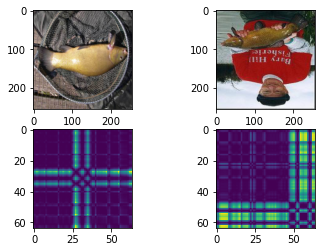

In [23]:
a = 109
b= 98
print(ds_train[a][1][1])
print(ds_train[b][1][1])

plt.subplot(221)
plt.imshow(ds_train[a][0].cpu().permute(1, 2, 0))
plt.subplot(222)
plt.imshow(ds_train[b][0].cpu().permute(1, 2, 0))

plt.subplot(223)
plt.imshow(ds_train[a][1][0][0])
plt.subplot(224)
plt.imshow(ds_train[b][1][0][0])